Coefficients shape: (5,)
               Feature  Coefficient  Absolute_Coefficient
1         Junior_col_%     0.869530              0.869530
0      Physician_100kP     0.849678              0.849678
4  Socioeconomic_index     0.464524              0.464524
2          Park_Land_%     0.455599              0.455599
3     Ambulances_100kP     0.174815              0.174815


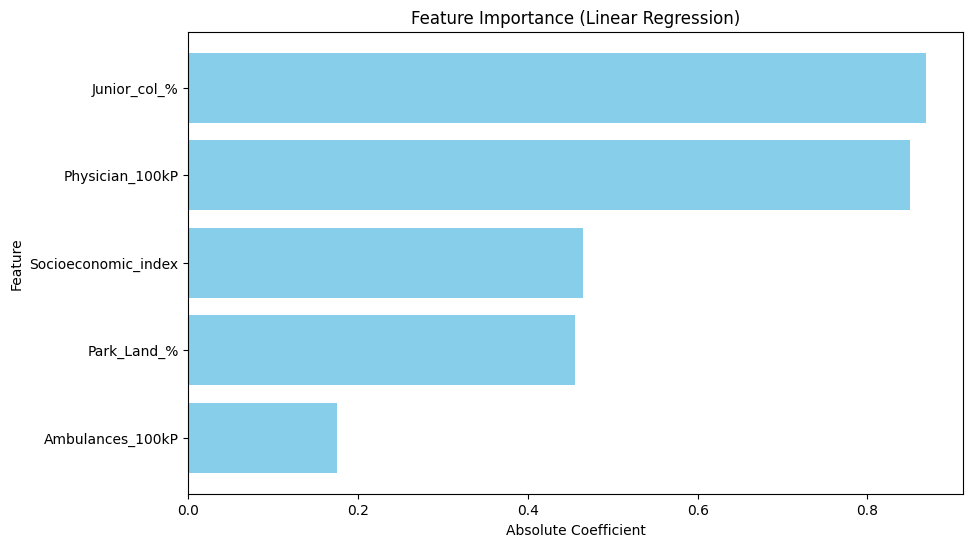

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# Load the trained linear regression model
model = joblib.load("../models/model_linear_regression_pca.pkl")

# Retrieve coefficients
coefficients = model.coef_
features = ['Physician_100kP', 'Junior_col_%', 'Park_Land_%', 'Ambulances_100kP', 'Socioeconomic_index']
coefficients = coefficients.flatten()

# Ensure coefficients are 1D
print(f"Coefficients shape: {coefficients.shape}")  # Should print (n_features,)

# Combine features and coefficients into a DataFrame for readability
importance_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients
})
importance_df["Absolute_Coefficient"] = importance_df["Coefficient"].abs()

# Sort coefficients by their absolute magnitude
importance_df = importance_df.sort_values(by="Absolute_Coefficient", ascending=False)

# Display sorted coefficients
print(importance_df)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Absolute_Coefficient"], color='skyblue')
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")
plt.title("Feature Importance (Linear Regression)")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

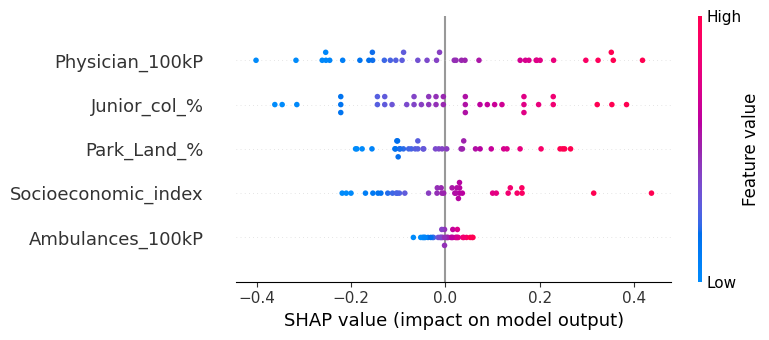

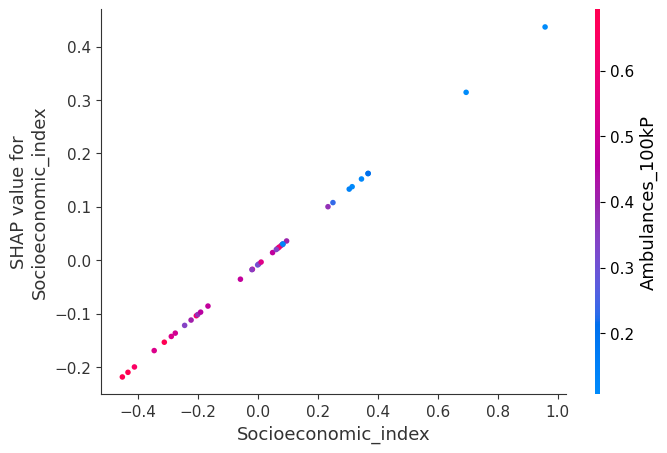

In [ ]:
#SHAP
import shap
from sklearn.linear_model import LinearRegression
import seaborn as sns
#explain de model prediction using SHAP
X_train=pd.read_excel('~/Library/CloudStorage/OneDrive-国立大学法人東海国立大学機構/Weekly_challenges/Data science and Analytics/Japan_Life_Expectency/data/processed/Cleaned_Japan_Life_Expectancy_X_train.xlsx')
y_train=pd.read_excel('~/Library/CloudStorage/OneDrive-国立大学法人東海国立大学機構/Weekly_challenges/Data science and Analytics/Japan_Life_Expectency/data/processed/Cleaned_Japan_Life_Expectancy_y_train.xlsx')
y_train=y_train.values.flatten()
X_train_PCA=X_train.drop(['University_%', 'Salary', 'Elementary_school'], axis=1)

explainer=shap.LinearExplainer(model, X_train_PCA)
shap_values=explainer(X_train_PCA)
#summary plot
shap.summary_plot(shap_values, X_train_PCA)

shap_values_array=shap_values.values
#SHAP dependance plot to visualize interactions along with the most interacting feature
shap.dependence_plot("Socioeconomic_index", shap_values_array, X_train_PCA.values, feature_names=X_train_PCA.columns)


(37,)
(37,)


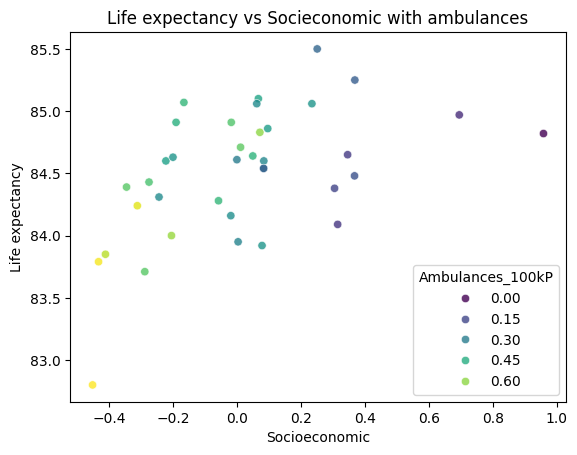

<Axes: xlabel='Physician_100kP'>

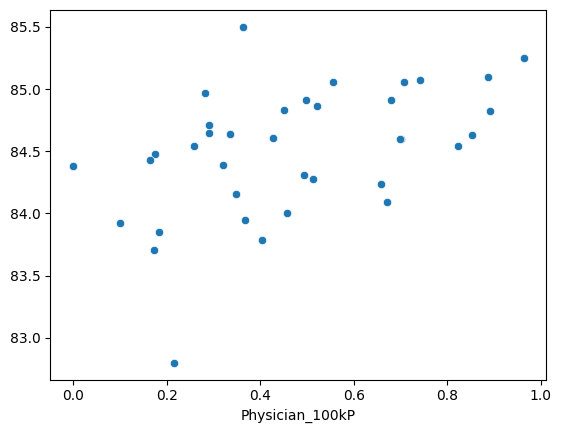

In [52]:
#Interpretation
#scatter plot: socioeconomic vs life expectancy with ambulances as color
print(f"{X_train_PCA['Ambulances_100kP'].shape}")
print(f"{y_train.shape}")
sns.scatterplot(x=X_train_PCA['Socioeconomic_index'], y=y_train, hue=X_train_PCA['Ambulances_100kP'], palette='viridis', alpha=0.8)
plt.title('Life expectancy vs Socieconomic with ambulances')
plt.xlabel('Socioeconomic')
plt.ylabel('Life expectancy')
plt.show()
#scatter plot: Physician vs life expectancy with 
sns.scatterplot(x=X_train_PCA['Physician_100kP'], y=y_train)


                     Life_expectancy  Physician_100kP  Junior_col_%  \
Life_expectancy             1.000000         0.321545      0.569207   
Physician_100kP             0.321545         1.000000     -0.035781   
Junior_col_%                0.569207        -0.035781      1.000000   
Park_Land_%                 0.333984        -0.142976      0.158243   
Ambulances_100kP           -0.305427         0.093529     -0.277607   
Socioeconomic_index         0.503219         0.049160      0.438652   

                     Park_Land_%  Ambulances_100kP  Socioeconomic_index  
Life_expectancy         0.333984         -0.305427             0.503219  
Physician_100kP        -0.142976          0.093529             0.049160  
Junior_col_%            0.158243         -0.277607             0.438652  
Park_Land_%             1.000000         -0.384330             0.350133  
Ambulances_100kP       -0.384330          1.000000            -0.744392  
Socioeconomic_index     0.350133         -0.744392        

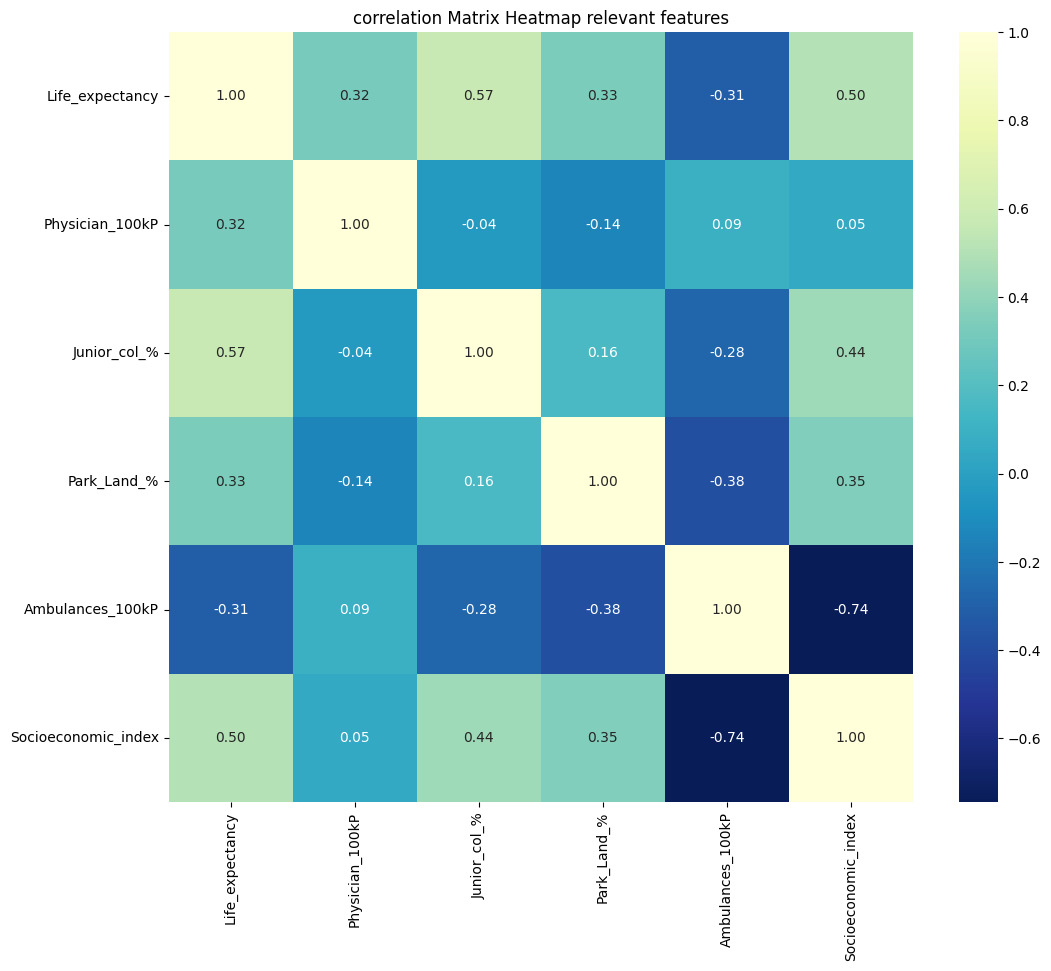

In [56]:
data=pd.read_excel('~/Library/CloudStorage/OneDrive-国立大学法人東海国立大学機構/Weekly_challenges/Data science and Analytics/Japan_Life_Expectency/data/processed/Cleaned_Japan_Life_Expectancy.xlsx')
#Heatmap
relevant_data=data[['Life_expectancy', 'Physician_100kP', 'Junior_col_%', 'Park_Land_%', 'Ambulances_100kP', 'Socioeconomic_index']]
#compute correlation matrix
plt.figure(figsize=(12, 10))
correlation_Matrix=relevant_data.corr()
print(correlation_Matrix)
#plot heatmap rounding to 2 decimals: Primary finding strong correlation between life expectancy and (people finished junior high school and college and higher salaries)
sns.heatmap(correlation_Matrix, annot=True, cmap="YlGnBu_r", fmt=".2f")
plt.title("correlation Matrix Heatmap relevant features")
plt.show()

# Observations from feature_engineering
# Linear regression model post PCA
`Coef_magnitude`:
- `Physician_100kP` ,`Junior_college_%`,have both a high impact on `Life_expectancy`  
- `Park_Land_%`, `Socioeconomic_index` ,`Ambulances_100kP` have a moderate impact on `Life_expectancy`  
`SHAP`:
- `Physician_100kP` ,`Junior_college_%`,have both a high impact on `Life_expectancy`  
- `Park_Land_%`, `Socioeconomic_index` ,`Ambulances_100kP` have a moderate impact on `Life_expectancy`  
- `Shap_dependance_plot` shows an inverse relationship between `Socioeconomic_index` and the number of `Ambulances_100kP` . Higher `Socioeconomic_index` values (indicative of wealthier or more developed regions) are associated with fewer `Ambulances_100kP`, whereas lower `Socioeconomic_index` values (indicating poorer or less developed regions) tend to have more ambulances.

  * Hypothesis: Areas with higher `Physician_100kP` ,`Junior_college_%`, `Park_Land_%` have higher life expectancy suggesting that Education, access to healthcare and park availability are not only associated with better physical health and disease prevention but also contribute to psychological well-being, which collectively enhances overall life expectancy.

  * Future metrics:
    - Include stress metrics, physical movement..